
#California Housing Dataset — Linear Regression (Step-by-Step, Beginner Friendly)



What you'll do:
1) Download + load the dataset (via **gdown**)  
2) Inspect + clean data (simple)  
3) Univariate plots (histograms)  
4) Single-variable Linear Regression (fit + plot)  
5) Multi-variable Linear Regression (fit + metrics)  
6) Diagnostic plots (residuals)  
7) Polynomial features + **GridSearchCV** to find the **best degree**  
8) Brief coefficient interpretation


## 0) Setup

In [ ]:
# 1. Install & Import

import sys, subprocess

def pip_install(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=False)

# Core libs
pip_install("pandas>=1.5")
pip_install("numpy>=1.23")
pip_install("matplotlib>=3.7")
pip_install("scikit-learn>=1.3")
pip_install("statsmodels>=0.14")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats


## 1) Download & Load the Dataset

In [ ]:

# 2. Load California Housing Dataset
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
df = housing.frame  # returns pandas DataFrame
df.head()

print("✅ California housing dataset loaded:", df.shape)
print(df.describe().T)


✅ California housing dataset loaded: (20640, 9)
               count         mean          std         min         25%  \
MedInc       20640.0     3.870671     1.899822    0.499900    2.563400   
HouseAge     20640.0    28.639486    12.585558    1.000000   18.000000   
AveRooms     20640.0     5.429000     2.474173    0.846154    4.440716   
AveBedrms    20640.0     1.096675     0.473911    0.333333    1.006079   
Population   20640.0  1425.476744  1132.462122    3.000000  787.000000   
AveOccup     20640.0     3.070655    10.386050    0.692308    2.429741   
Latitude     20640.0    35.631861     2.135952   32.540000   33.930000   
Longitude    20640.0  -119.569704     2.003532 -124.350000 -121.800000   
MedHouseVal  20640.0     2.068558     1.153956    0.149990    1.196000   

                     50%          75%           max  
MedInc          3.534800     4.743250     15.000100  
HouseAge       29.000000    37.000000     52.000000  
AveRooms        5.229129     6.052381    141.9090


### 📝 TODO
- Skim the first few rows above. What looks like a good **target** (y) for prediction (e.g., `mpg`, `price`)?


## 2) Quick Inspect & Simple Cleaning

In [ ]:
# 2) Quick Inspect & Simple Cleaning

print("Columns:", list(df.columns))
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

# Drop duplicates
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
print("\nDropped duplicates:", before - df.shape[0])

# Rename columns (optional: strip spaces / replace with underscore)
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

Columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']

Data types:
 MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

Missing values per column:
 MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

Dropped duplicates: 0



### 📝 TODO
- If you see obvious bad rows (e.g., impossible negative values), write one **extra line** to filter them out.


In [ ]:
df = df[(df["AveRooms"] < 20) & (df["AveBedrms"] < 10) & (df["AveOccup"] < 20)]


## 3) Choose Target and Features (Keep it Simple)

In [ ]:
# Step 3: Choose Target and Features (Keep it Simple)

# Target column
TARGET = "MedHouseVal"

# Use all other numeric columns as predictors
numeric_cols = [c for c in df.select_dtypes(include=np.number).columns if c != TARGET]

print("Target:", TARGET)
print("Numeric features:", numeric_cols)


Target: MedHouseVal
Numeric features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']



### 📝 TODO
- If you prefer different features, create a **manual list**, e.g.  
  `numeric_cols = ['horsepower','weight','displacement','acceleration']` (only if those exist).


In [ ]:
numeric_cols = [
    "MedInc",      # Median income (very strong predictor of house price)
    "HouseAge",    # Age of houses
    "AveRooms",    # Average number of rooms
    "Latitude",    # Location effect (north-south)
    "Longitude"    # Location effect (east-west)
]

print("Target:", TARGET)
print("Selected numeric features:", numeric_cols)

Target: MedHouseVal
Selected numeric features: ['MedInc', 'HouseAge', 'AveRooms', 'Latitude', 'Longitude']


## 4) Univariate Plots (Matplotlib)

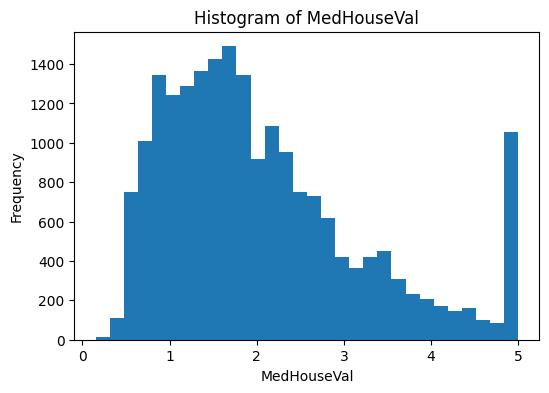

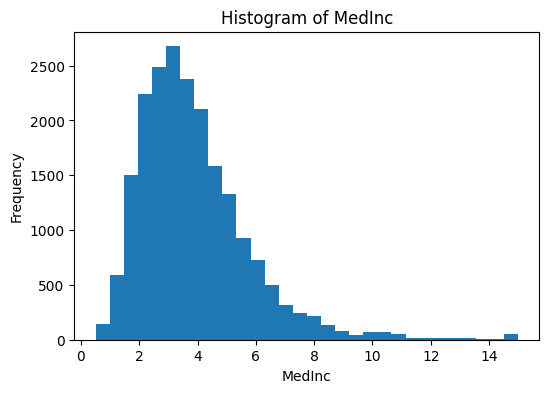

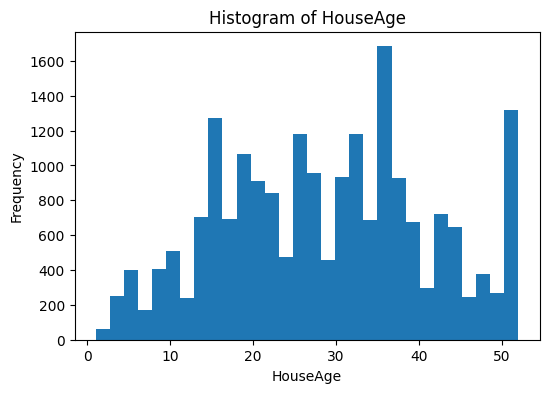

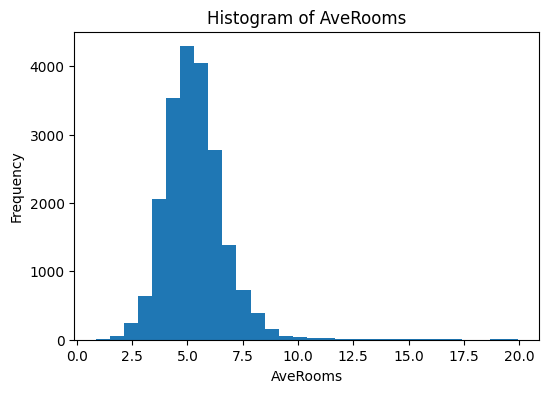

In [ ]:
# Step 4: Univariate Plots (Matplotlib)

import matplotlib.pyplot as plt

# Plot target histogram
if TARGET in df.columns and pd.api.types.is_numeric_dtype(df[TARGET]):
    plt.figure(figsize=(6,4))
    df[TARGET].plot(kind='hist', bins=30, title=f"Histogram of {TARGET}")
    plt.xlabel(TARGET); plt.ylabel("Frequency")
    plt.show()

# Plot up to 3 numeric features' histograms
for col in numeric_cols[:3]:
    plt.figure(figsize=(6,4))
    df[col].plot(kind='hist', bins=30, title=f"Histogram of {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.show()



### 📝 TODO
- Looking at the histograms, note any skewed variables or outliers.


Target (MedHouseVal) → right-skewed, capped at 5.0.

MedInc (Median Income) → right-skewed, some high-income outliers.

HouseAge → capped at 52 years, bunching at the max.

AveRooms / AveBedrms → strongly right-skewed with extreme outliers.

## 5) Single-Variable Linear Regression

Feature: Population
Coefficient (slope): -2.9029737097259232e-05
Intercept: 2.11141978806333
R^2 (test): -1.8395838788931584e-05


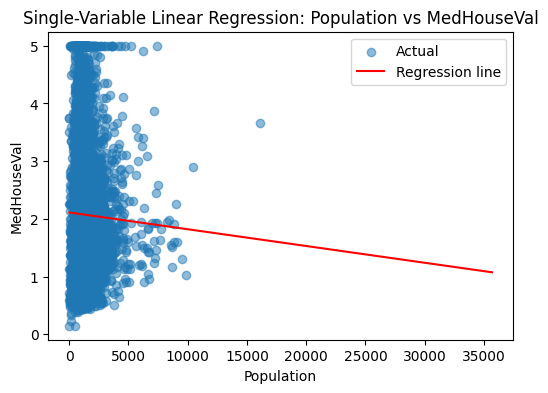

In [ ]:
FEATURE_X = "Population"   # you can change to 'HouseAge', 'AveRooms', etc.

# Drop NA values
data_1v = df[[FEATURE_X, TARGET]].dropna().copy()
X = data_1v[[FEATURE_X]].values
y = data_1v[TARGET].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

print("Feature:", FEATURE_X)
print("Coefficient (slope):", lr.coef_[0])
print("Intercept:", lr.intercept_)
print("R^2 (test):", r2_score(y_test, y_pred))

# Plot scatter + regression line
plt.figure(figsize=(6,4))
plt.scatter(X_test, y_test, alpha=0.5, label="Actual")
x_line = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
y_line = lr.predict(x_line)
plt.plot(x_line, y_line, color="red", label="Regression line")
plt.xlabel(FEATURE_X); plt.ylabel(TARGET)
plt.title(f"Single-Variable Linear Regression: {FEATURE_X} vs {TARGET}")
plt.legend()
plt.show()


### 📝 TODO
- Change `FEATURE_X` to a different column and re-run.
- Does the line slope match your intuition about the relationship?


When the FEATURE_X is changed,the values like slope,intercept and R^2 changes.

In some Scenario,the slope is positivw where as for some is it negative.

## 6) Multi-Variable Linear Regression (Simple)

In [ ]:
# Keep only numeric predictors + target; drop NA
data_mv = df[numeric_cols + [TARGET]].dropna().copy()

X = data_mv[numeric_cols].values
y = data_mv[TARGET].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
lin = LinearRegression()
lin.fit(X_train, y_train)

# Predict
y_pred = lin.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.3f}")
print(f"MSE:  {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2:  {r2:.3f}")


MAE:  0.547
MSE:  0.549
RMSE: 0.741
R^2:  0.598



### 📝 TODO
- Remove one weak feature from `numeric_cols` and see how metrics change.
- Add a different feature and compare.


The values of R^2 and RMSE change according to features.

## 7) Diagnostic Plots (Residuals)

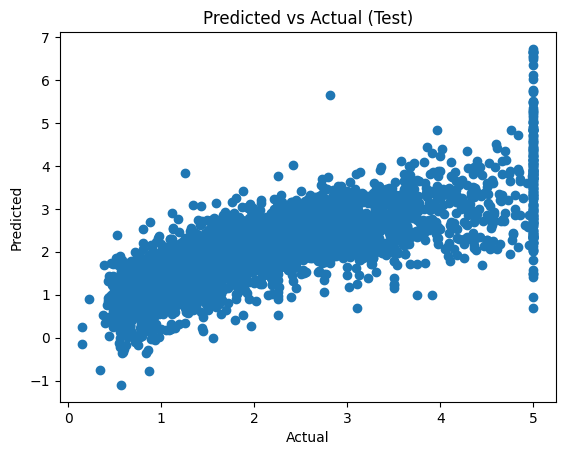

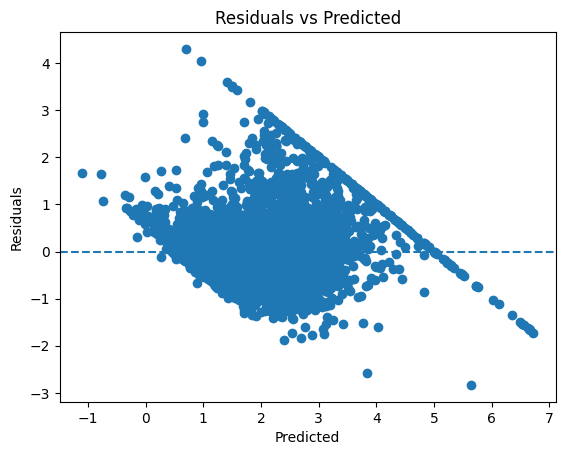

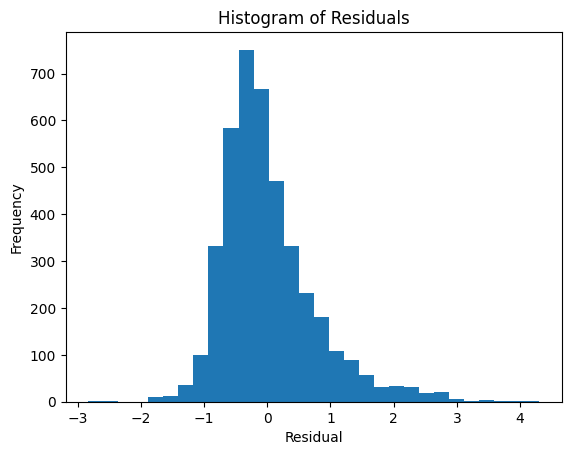

In [ ]:

# Reuse y_test and y_pred from multi-variable model
residuals = y_test - y_pred

# Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Test)")
plt.show()

# Residuals vs Predicted
plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted"); plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

# Histogram of residuals
plt.figure()
pd.Series(residuals).plot(kind='hist', bins=30, title="Histogram of Residuals")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.show()



### 📝 TODO
- Do residuals look roughly centered around 0 and evenly spread?
- If not, which assumption might be violated?


1)Predicted vs Actual	Points -close to 45°-line	Linearity assumption

2)Residuals vs Predicted-Random cloud around 0-Linearity or homoscedasticity assumption

3)Histogram of Residuals-Symmetric, bell-shaped-Normality of errors assumption

## 8) Polynomial Features + Grid Search for Best Degree


Even though it's called "polynomial regression", it's still **linear regression** applied to **polynomially-expanded features**.
We'll try degrees **1 to 5** on a **single predictor** and pick the degree with the best cross-validated **R²**.


Best params: {'lr__fit_intercept': True, 'poly__degree': 1}
Best CV R^2: -0.09493767160482629


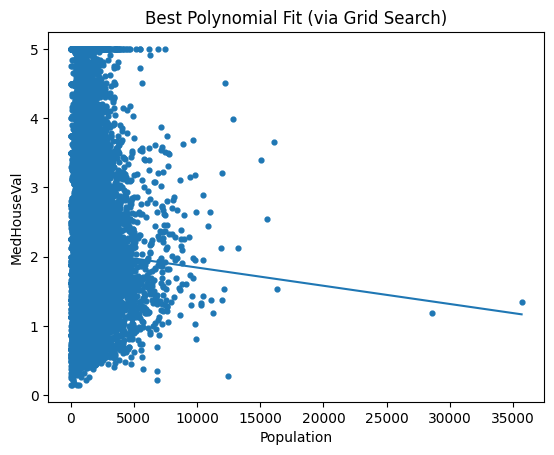

In [ ]:

# Choose a single predictor again (same FEATURE_X as before by default)
FEATURE_X = FEATURE_X  # keep same, or set to something else like 'horsepower'

poly_data = df[[FEATURE_X, TARGET]].dropna().copy()
X = poly_data[[FEATURE_X]].values
y = poly_data[TARGET].values

pipe = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("lr", LinearRegression())
])

param_grid = {
    "poly__degree":list(range(1,9)),
    "lr__fit_intercept": [True, False]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best CV R^2:", grid.best_score_)

best_model = grid.best_estimator_

# Plot best curve
x_line = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
y_line = best_model.predict(x_line)

plt.figure()
plt.scatter(X, y, s=12)
plt.plot(x_line, y_line)
plt.xlabel(FEATURE_X); plt.ylabel(TARGET)
plt.title("Best Polynomial Fit (via Grid Search)")
plt.show()



### 📝 TODO
- Change the degree range (e.g., 1–8) and re-run. Does performance keep improving?
- Try a different `FEATURE_X`.


R^2 does not improve.It is same as before

## 9) Interpreting Coefficients (Multi-Variable Model)

In [ ]:

# Show top coefficients by magnitude (multi-variable linear model)
coef = lin.coef_
coef_df = pd.DataFrame({"feature": numeric_cols, "coefficient": coef})
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df.sort_values("abs_coef", ascending=False, inplace=True)
coef_df.drop(columns=["abs_coef"], inplace=True)
coef_df.head(10)


,feature,coefficient
4,Longitude,-0.445934
3,Latitude,-0.439785
0,MedInc,0.386918
2,AveRooms,-0.018383
1,HouseAge,0.008889



### 📝 TODO
- Which features have the largest (absolute) coefficients?
- Do the signs (+/-) match your intuition?


1)Longitude,latitude,MedInc have largest coefficients.

2)MedInc,HouseAge match


## 10) Linear Regression — Quick Assumptions Checklist
- **Linearity**: Relationship between predictors and target is roughly linear.
- **Independence**: Errors are independent.
- **Homoscedasticity**: Residuals have constant variance.
- **Normality (for inference)**: Residuals are roughly normal.
- **No perfect multicollinearity**: Avoid duplicate/linearly dependent features.



## 11) Assumption Checks — Code You Can Run
We'll check the classic linear regression assumptions using simple, readable code:
- **Linearity & Homoscedasticity:** residuals vs predicted plot
- **Normality of residuals:** Q–Q plot and Shapiro–Wilk test
- **Independence of errors:** Durbin–Watson statistic
- **Multicollinearity:** Variance Inflation Factor (VIF)


In [ ]:

#@title Install test libs (statsmodels) if needed
import sys, subprocess
def pip_install(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=False)

try:
    import statsmodels
except:
    pip_install("statsmodels>=0.14")
    import statsmodels

from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# NOTE: This cell assumes you've already run the multi-variable model section
# so that y_test, y_pred, X_train, X_test, numeric_cols, TARGET are defined.
# If not, re-run sections 6 and 7.


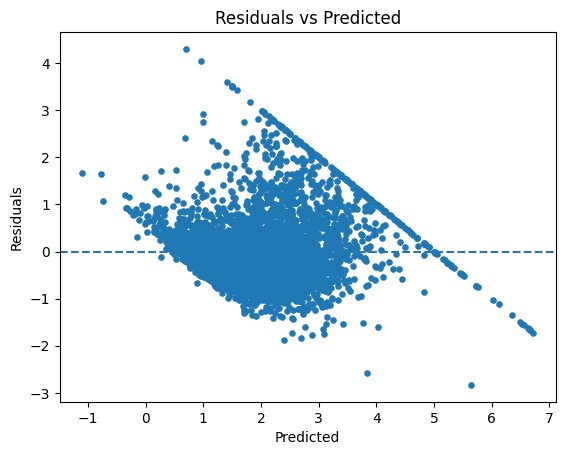

🧐 Look for: no obvious curve/pattern; spread roughly constant across x-axis.


In [ ]:

# 11.1 Linearity & Homoscedasticity (visual)
# Residuals vs Predicted should look like a random cloud around 0 (no pattern / fanning)

residuals = y_test - y_pred

plt.figure()
plt.scatter(y_pred, residuals, s=14)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

print("🧐 Look for: no obvious curve/pattern; spread roughly constant across x-axis.")


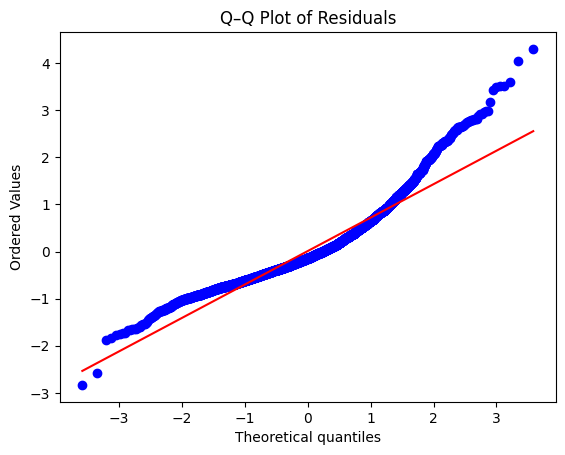

Shapiro–Wilk: statistic=0.917, p-value=8.78e-43
Rule of thumb: p-value > 0.05 suggests residuals are close to normal (for inference).


In [ ]:

# 11.2 Normality of residuals: Q–Q plot + Shapiro–Wilk test
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q–Q Plot of Residuals")
plt.show()

sh_stat, sh_p = stats.shapiro(residuals)
print(f"Shapiro–Wilk: statistic={sh_stat:.3f}, p-value={sh_p:.3g}")
print("Rule of thumb: p-value > 0.05 suggests residuals are close to normal (for inference).")


In [ ]:

# 11.3 Independence of errors: Durbin–Watson (≈2 is good; <1 or >3 indicates strong autocorrelation)
dw = durbin_watson(residuals)
print(f"Durbin–Watson statistic = {dw:.3f}")
print("Guideline: ~2 means uncorrelated; much below 2 ⇒ positive autocorrelation; much above 2 ⇒ negative autocorrelation.")


Durbin–Watson statistic = 2.016
Guideline: ~2 means uncorrelated; much below 2 ⇒ positive autocorrelation; much above 2 ⇒ negative autocorrelation.


In [ ]:

# 11.4 Homoscedasticity formal test: Breusch–Pagan
# Use original predictors (X_test). Add constant for the test design matrix.

X_bp = sm.add_constant(pd.DataFrame(X_test, columns=numeric_cols))
bp_stat, bp_p, _, _ = het_breuschpagan(residuals, X_bp)
print(f"Breusch–Pagan: stat={bp_stat:.3f}, p-value={bp_p:.3g}")
print("Rule of thumb: p-value > 0.05 ⇒ no strong evidence of heteroscedasticity.")


Breusch–Pagan: stat=123.928, p-value=4.62e-25
Rule of thumb: p-value > 0.05 ⇒ no strong evidence of heteroscedasticity.


In [ ]:

# Prepare dataframe with constant
X_vif = pd.DataFrame(X_train, columns=numeric_cols).dropna()
X_vif_const = sm.add_constant(X_vif)

vif_vals = []

for i in range(1, X_vif_const.shape[1]):  # start at 1 to skip 'const'
    col_name = X_vif_const.columns[i]
    vif = variance_inflation_factor(X_vif_const.values, i)
    vif_vals.append({"feature": col_name, "VIF": vif})

vif_df = pd.DataFrame(vif_vals).sort_values("VIF", ascending=False)
vif_df


,feature,VIF
3,Latitude,9.565695
4,Longitude,9.251765
0,MedInc,1.934226
2,AveRooms,1.895489
1,HouseAge,1.115122



### 📝 TODO
- If **Breusch–Pagan p < 0.05**, try transforming a skewed feature (e.g., `np.log1p(x)`) and re-fit.  
- If **Shapiro p < 0.05**, consider outliers or feature transforms.  
- If **VIF > 10** for a feature, try removing it or combining highly correlated features.  
- If **Durbin–Watson** is far from 2 (time-indexed data), try adding lag features or using time-series models.
